# ARMA Model

Import Libraries

In [50]:
import pandas as pd
from data import OpenmeteoAPI, SQLRespository
import sqlite3
from config import settings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns


### Prepare Data

API CALL

For the purpose of this project, i will be getting my PM2.5 data using [Open Metro](https://open-meteo.com/) Api just as if have done in `air_quality1.ipynb` Notebook.

In [13]:
# open_api = OpenmeteoAPI()
# record = open_api.getPM2_5(lat=7.403546223182103, lon=3.932032049519837, start_date="2024-01-01", end_date="2024-12-18")
# record

In [14]:
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
repo = SQLRespository(connection=connection)

In [15]:
# repo.insert_table(table_name="PM2_5", records=record)

In [16]:
df = repo.read_table(table_name="PM2_5")

# Rename pm2_5 to PM2.5
df.rename(columns={"pm2_5" : "PM2.5"}, inplace=True)
df

,PM2.5
date,
2023-12-31 23:00:00+00:00,132.699997
2024-01-01 00:00:00+00:00,131.300003
2024-01-01 01:00:00+00:00,128.100006
2024-01-01 02:00:00+00:00,126.199997
2024-01-01 03:00:00+00:00,124.800003
...,...
2024-12-18 18:00:00+00:00,116.400002
2024-12-18 19:00:00+00:00,140.199997
2024-12-18 20:00:00+00:00,154.100006


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8472 entries, 2023-12-31 23:00:00+00:00 to 2024-12-18 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   8472 non-null   float64
dtypes: float64(1)
memory usage: 132.4+ KB


The data should be format to Series.} 

In [18]:
y = df["PM2.5"]
print(type(y))
y

<class 'pandas.core.series.Series'>


date
2023-12-31 23:00:00+00:00    132.699997
2024-01-01 00:00:00+00:00    131.300003
2024-01-01 01:00:00+00:00    128.100006
2024-01-01 02:00:00+00:00    126.199997
2024-01-01 03:00:00+00:00    124.800003
                                ...    
2024-12-18 18:00:00+00:00    116.400002
2024-12-18 19:00:00+00:00    140.199997
2024-12-18 20:00:00+00:00    154.100006
2024-12-18 21:00:00+00:00    159.699997
2024-12-18 22:00:00+00:00    155.500000
Name: PM2.5, Length: 8472, dtype: float64

In [19]:
assert isinstance(y, pd.Series), f"`y` should be Series not type {type(y)}"
assert y.isnull().sum() == 0, f"`y` should not contain any null value"

### Explore

Plot ACF plot for data `y`

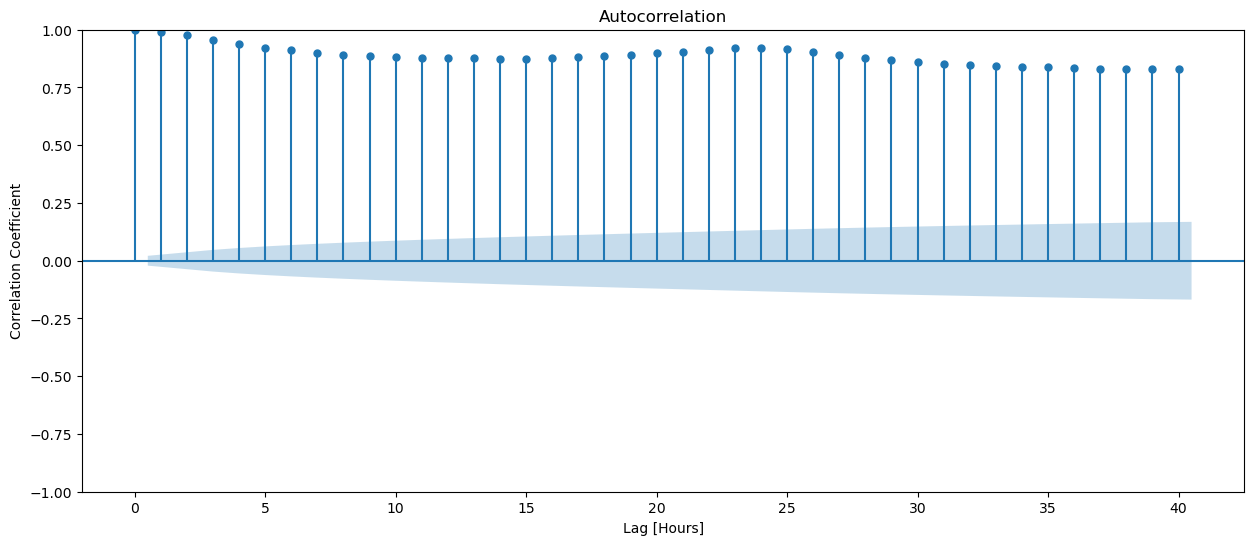

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

Plot PACF plot for data `y`

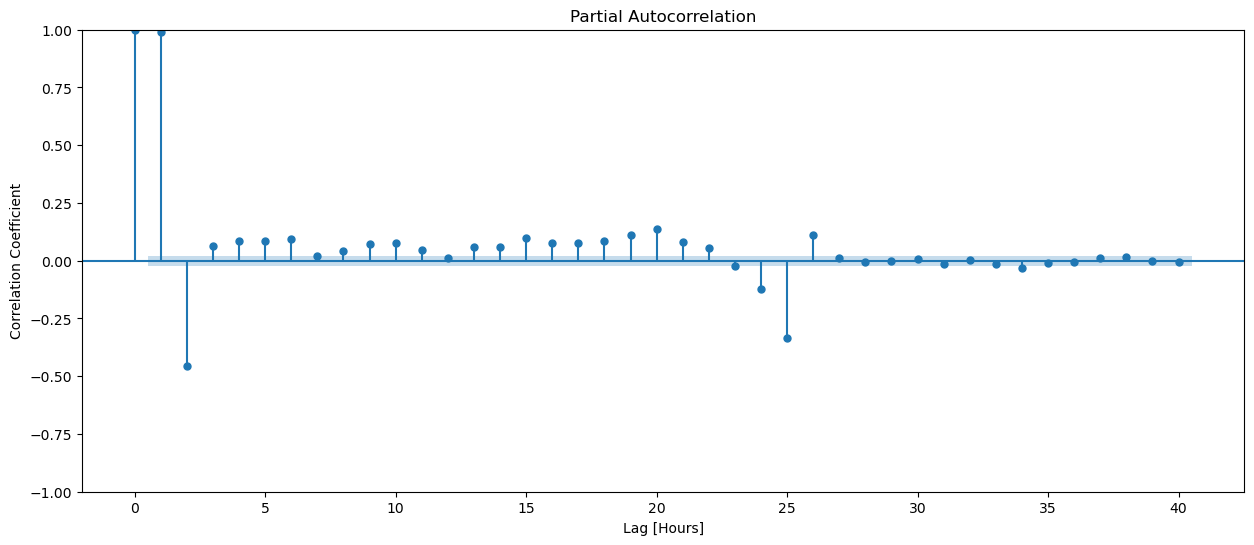

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficient")
plt.show();

### Split

Split `y` into training and test set. The first 95% should be training set and the remaining 5% should be in the test set. 

In [31]:
cut_off = int(len(y) * 0.95)
y_train = y.iloc[:cut_off]
y_test = y.iloc[cut_off:]

In [42]:
y_mean =  y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print(f"Mean PM2.5 Reading: {y_mean.round(2)}")
print(f"Baseline MAE: {baseline_mae.round(2)}")

Mean PM2.5 Reading: 34.69
Baseline MAE: 26.44


### Iterate

Hyperparameter tuning

In [43]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

Training a model with every combination of hyperparameters in `p_params` and `q_params`. Everytime the model is trained, mean absolute error is calculated and then save to dictionary

In [48]:
# Create dictionary to save MAE
import time


mae_grid = {}

# Outer loop : iterate through possible valuse for `p`
for p in p_params:
    # Create key-value pair. Key is `p` and value is empty list
    mae_grid[p] = list() 
    # Inner loop : Iterate possible values of `q`
    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        # Combination of hyperparameters for the model
        model = ARIMA(y_train, order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds")
        # Generate in-sample training predictions
        y_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(y_train, y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (0, 0, 0) in 1.46 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (0, 0, 1) in 1.76 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (0, 0, 2) in 5.41 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 0) in 6.68 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (8, 0, 1) in 18.82 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 2) in 19.37 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (16, 0, 0) in 8.48 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (16, 0, 1) in 41.34 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (16, 0, 2) in 38.91 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (24, 0, 0) in 25.44 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Trained ARIMA (24, 0, 1) in 47.96 seconds


c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\taofe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (24, 0, 2) in 75.19 seconds

{0: [26.43669810338082, 13.977257048848934, 8.480795569726638], 8: [2.2788104387835975, 2.228451419602571, 2.2224432018651408], 16: [2.243990632684455, 2.223582467171888, 2.2253798702687004], 24: [2.177962152505174, 2.204330239197858, 2.18473192399939]}


Organizing the MAE from the above into DataFrame so that each row represent possible value for **q** and each column represents possible values for **p**.

In [49]:
mae_df = pd.DataFrame(mae_grid)
mae_df

,0,8,16,24
0,26.436698,2.278810,2.243991,2.177962
1,13.977257,2.228451,2.223582,2.204330
2,8.480796,2.222443,2.225380,2.184732


Heatmap of the values in `mae_df`

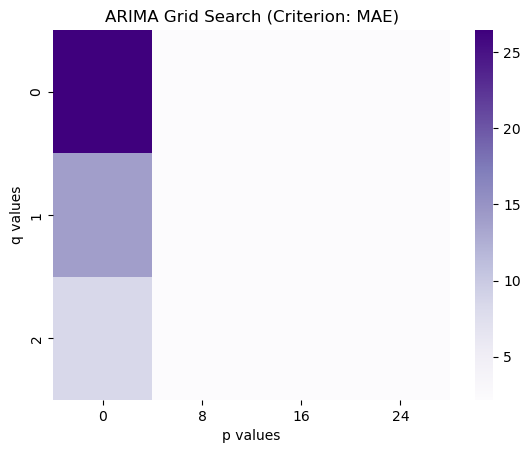

In [56]:
sns.heatmap(mae_df, cmap="Purples")
plt.xlabel("p values")
plt.ylabel("q values")
plt.title("ARIMA Grid Search (Criterion: MAE)");

Using `plot_diagnostics` method to check residuals for the model

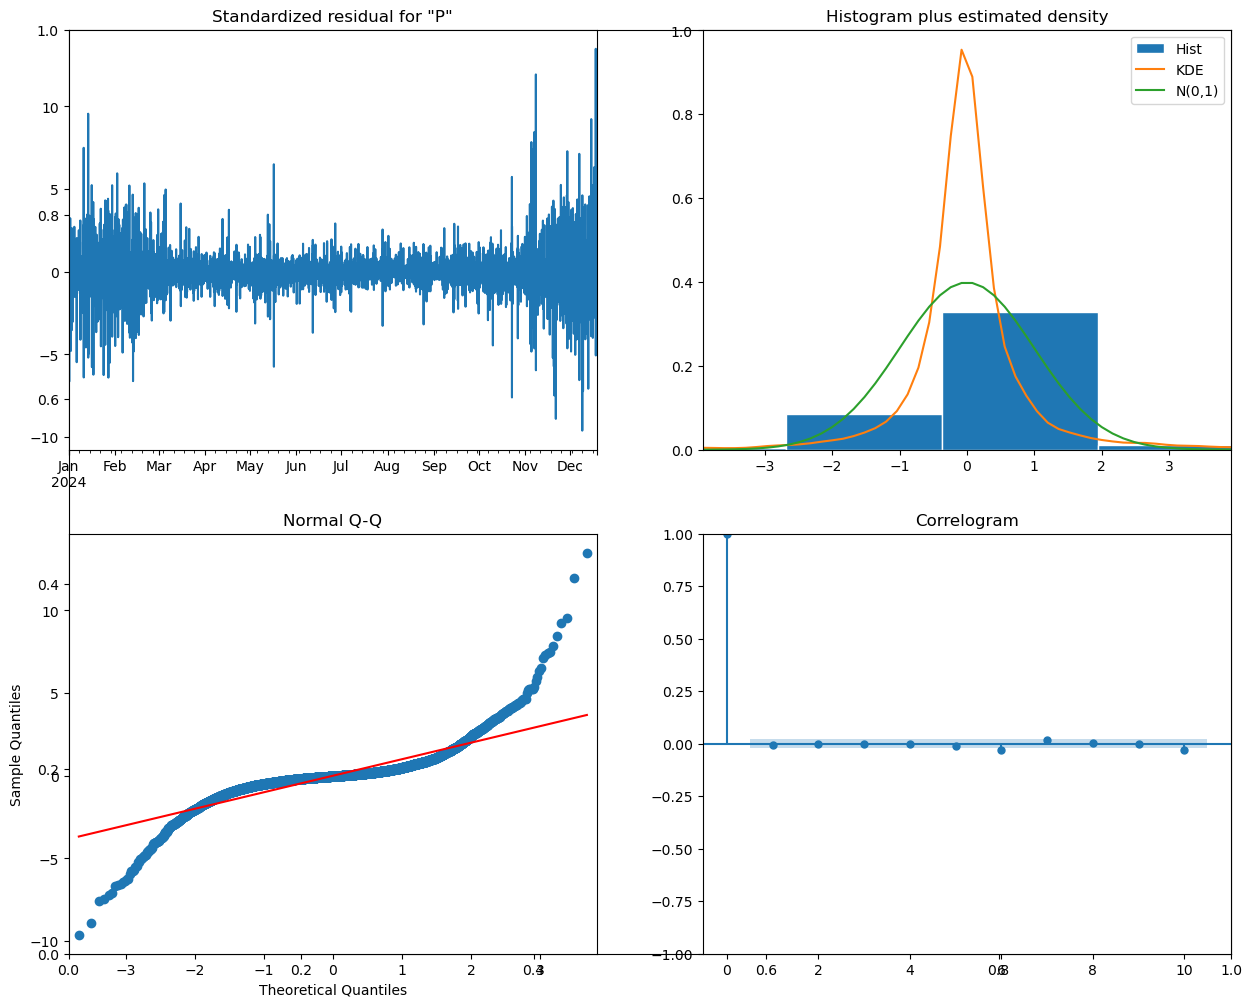

In [62]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

Performing walk-forward validation for the entire test set `y_test` choosing the values for `p` and `q` that best balance model performance and computation time.

In [58]:
%%capture
y_pred_wfv = pd.Series(dtype=float)
history = y_train.copy()

# Walk-forward validation
for i in range(len(y_test)):
    # Fit the AutoReg model
    model = ARIMA(history, order=(8, 0, 1)).fit()
    # Forecast the next value
    next_pred = model.forecast(steps=1)
    # Append the forecast to the predictions
    y_pred_wfv = pd.concat([y_pred_wfv, pd.Series(next_pred, index=[y_test.index[i]])])
    # Update history with the true value from the test set
    history = pd.concat([history, y_test.iloc[i:i+1]])
    

In [59]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (Walk forward validation): ", round(test_mae, 2))

Test MAE (Walk forward validation):  6.17


### Results

Create DataFrame that has two columns: `y_test` and `y_pred_wfv`

In [60]:
df_pred_test = pd.DataFrame({
    "y_test" : y_test,
    "y_pred_wfv" : y_pred_wfv
}, index = y_test.index)

df_pred_test

,y_test,y_pred_wfv
date,,
2024-12-01 07:00:00+00:00,68.699997,64.589615
2024-12-01 08:00:00+00:00,77.099998,75.490900
2024-12-01 09:00:00+00:00,84.300003,82.476286
2024-12-01 10:00:00+00:00,85.199997,88.614961
2024-12-01 11:00:00+00:00,81.000000,86.066258
...,...,...
2024-12-18 18:00:00+00:00,116.400002,105.490757
2024-12-18 19:00:00+00:00,140.199997,130.568815
2024-12-18 20:00:00+00:00,154.100006,150.774388


A line plot of `y_test` and `y_pred_wfv` in **test_predictions**

In [61]:
fig = px.line(df_pred_test, labels={"value" : "PM2.5"})
fig.show()